In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.io import loadmat, savemat

# =========================
# CONFIGURACIÓN
# =========================
PROJECT_ROOT = Path("..").resolve()
DATA_DIR = PROJECT_ROOT / "data"

RAW_SIGNALS_DIR = DATA_DIR / "ROISignals_FunImgARWSDCFN"
PIPE_META_CSV   = DATA_DIR / "covid_pipeline_metadata.csv"
PIPE_QC_CSV     = DATA_DIR / "covid_pipeline_qc.csv"

# Carpeta nueva para los datos limpios
TARGET_LEN_TS = 140
TRUNC_SIGNALS_DIR = DATA_DIR / f"ROISignals_COVID_CLEAN_TP{TARGET_LEN_TS}"

# =========================
# Helpers
# =========================
def infer_ts_from_mat(mat_path: Path):
    d = loadmat(mat_path)
    # Buscar el array de datos
    arrays = [(k, v) for k, v in d.items() if not k.startswith("__") and isinstance(v, np.ndarray)]
    if not arrays: raise ValueError("No data found")
    varname, X = max(arrays, key=lambda kv: kv[1].size)
    
    # Orientar (TP, ROIs)
    # Asumimos que si una dimensión es 170 (AAL3), esa es la de ROIs
    if X.shape[1] in [170, 166, 131]: 
        pass # Ya está bien (TP, ROI)
    elif X.shape[0] in [170, 166, 131]:
        X = X.T # Transponer a (TP, ROI)
    
    return varname, np.asarray(X, dtype=np.float32)

# =========================
# PROCESAMIENTO
# =========================
meta = pd.read_csv(PIPE_META_CSV)
sids = meta["SubjectID"].astype(str).tolist()

TRUNC_SIGNALS_DIR.mkdir(parents=True, exist_ok=True)

rows = []
n_written = 0

print(f"Iniciando limpieza de {len(sids)} sujetos...")

for sid in sids:
    # Nota: Tu CSV tiene IDs tipo 'CP0001', pero el archivo es 'ROISignals_CP0001.mat'
    # El script del pipeline espera ROISignals_{id}.mat, así que buscamos ese archivo.
    filename = f"ROISignals_{sid}.mat"
    mat_path = RAW_SIGNALS_DIR / filename

    if not mat_path.exists():
        rows.append({"SubjectID": sid, "ToDiscard_Overall": True, "DiscardReason": "missing_file"})
        continue

    try:
        varname, X = infer_ts_from_mat(mat_path)
        
        # --- PASO CRÍTICO 1: LIMPIEZA DE NaNs ---
        if np.isnan(X).any():
            # Reemplazar NaNs con Cero
            X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
            was_cleaned = True
        else:
            was_cleaned = False
            
        tps, nroi = X.shape
        
        # --- PASO CRÍTICO 2: LONGITUD ---
        if tps < TARGET_LEN_TS:
            # Demasiado corto (esos 2 casos que viste) -> DESCARTAR
            rows.append({
                "SubjectID": sid, 
                "ToDiscard_Overall": True, 
                "DiscardReason": f"too_short_{tps}<{TARGET_LEN_TS}"
            })
        else:
            # Longitud correcta o mayor -> TRUNCAR y GUARDAR
            X_clean = X[:TARGET_LEN_TS, :] # Tomar primeros 140
            
            # Guardar en la nueva carpeta
            out_path = TRUNC_SIGNALS_DIR / filename
            savemat(out_path, {varname: X_clean}, do_compression=True)
            n_written += 1
            
            rows.append({
                "SubjectID": sid, 
                "ToDiscard_Overall": False, 
                "TimePoints": TARGET_LEN_TS, # Ahora todos tienen 140
                "DiscardReason": "Cleaned_NaNs" if was_cleaned else "OK"
            })

    except Exception as e:
        rows.append({"SubjectID": sid, "ToDiscard_Overall": True, "DiscardReason": str(e)})

# Guardar QC Final
qc_df = pd.DataFrame(rows)
qc_df.to_csv(PIPE_QC_CSV, index=False)

print("\n=== RESUMEN DE LIMPIEZA ===")
print(f"Total Procesados: {len(qc_df)}")
print(f"✅ APROBADOS (Guardados en carpeta limpia): {n_written}")
print(f"❌ DESCARTADOS: {len(qc_df) - n_written}")
print("\nRazones de descarte:")
print(qc_df[qc_df['ToDiscard_Overall']==True]['DiscardReason'].value_counts())

print(f"\n📂 Nueva carpeta de señales: {TRUNC_SIGNALS_DIR}")

Iniciando limpieza de 214 sujetos...

=== RESUMEN DE LIMPIEZA ===
Total Procesados: 214
✅ APROBADOS (Guardados en carpeta limpia): 194
❌ DESCARTADOS: 20

Razones de descarte:
DiscardReason
missing_file         18
too_short_100<140     1
too_short_117<140     1
Name: count, dtype: int64

📂 Nueva carpeta de señales: /home/diego/proyectos/betavae-xai-ad/data/ROISignals_COVID_CLEAN_TP140


In [2]:
import sys
# Asegurar que Python vea la carpeta src
if str(PROJECT_ROOT / "src") not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT / "src"))

from betavae_xai import feature_extraction_manual_COVID as fem_covid
from importlib import reload

# Recargar para asegurar cambios recientes
reload(fem_covid)

# Definir argumentos para el CLI
args_covid = [
    # -- Identificación --
    "--dataset_name", "COVID_Cohorte",
    "--data_root", str(DATA_DIR),
    "--output_dir_name_base", "COVID_AAL3_Tensor_v1", # Carpeta de salida distintiva
    
    # -- Rutas Dinámicas (Las que acabamos de crear) --
    "--subject_metadata_csv", str(PIPE_META_CSV),
    "--qc_report_csv", str(PIPE_QC_CSV),
    "--roi_signals_dir", str(TRUNC_SIGNALS_DIR),
    
    # -- Configuración del Atlas (USAR LA ORIGINAL DE ADNI PARA COMPATIBILIDAD) --
    # No cambies esto, o el VAE no entenderá los datos
    "--aal3_meta_path", str(DATA_DIR / "ROI_MNI_V7_vol.txt"), 
    "--aal3_manual_mapping_csv", str(DATA_DIR / "aal3_131_manual_network_order.csv"),
    
    # -- Parámetros Técnicos --
    "--roi_filename_template", "ROISignals_{subject_id}.mat", # CP0001 -> ROISignals_CP0001.mat
    "--raw_expected_columns", "170", # Tus datos COVID tienen 170 columnas
    "--target_len_ts", "140",
    "--tr_seconds", "3.0",
    
    # -- Canales a Calcular --
    "--use_granger_channel", # Incluir si quieres Granger
    # "--max_workers", "4" # Descomentar si quieres limitar CPU
]

print("🚀 Iniciando Extracción de Características para COVID...")
print("Argumentos:", args_covid)

qc = pd.read_csv(PIPE_QC_CSV)
print("QC path:", PIPE_QC_CSV)
print(qc["ToDiscard_Overall"].value_counts(dropna=False))
print(qc.loc[qc["ToDiscard_Overall"] == True, "DiscardReason"].value_counts())

qc = pd.read_csv(PIPE_QC_CSV)
approved = set(qc.loc[qc["ToDiscard_Overall"] == False, "SubjectID"].astype(str))
files = {p.stem.replace("ROISignals_", "") for p in TRUNC_SIGNALS_DIR.glob("ROISignals_*.mat")}

print("Approved in QC:", len(approved))
print("Files in clean dir:", len(files))
print("Missing files among approved (should be 0):", len(approved - files))
print("Extra files not in approved (ok if 0):", len(files - approved))



# Ejecutar
fem_covid.main(args_covid)

2026-02-05 20:28:19,352 - INFO - feature_extraction_manual_COVID.py:53 - Successfully imported 'threshold_omst_global_cost_efficiency' from 'dyconnmap.graphs.threshold' and aliased as 'orthogonal_minimum_spanning_tree'.
2026-02-05 20:28:19,352 - INFO - feature_extraction_manual_COVID.py:194 - Global MAX_WORKERS for ProcessPoolExecutor set to: 6 (based on 12 total cores)
2026-02-05 20:28:19,353 - CRITICAL - feature_extraction_manual_COVID.py:717 - !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
2026-02-05 20:28:19,353 - CRITICAL - feature_extraction_manual_COVID.py:718 - !! CRÍTICO: Este script ASUME que las señales BOLD de los ROIs ya han sido PREPROCESADAS RIGUROSAMENTE !!
2026-02-05 20:28:19,353 - CRITICAL - feature_extraction_manual_COVID.py:719 - !! La calidad de las matrices de conectividad depende DIRECTAMENTE de este preprocesamiento previo.     !!
2026-02-05 20:28:19,354 - CRITICAL - feature_extraction_manual_COVID.py:720 - !

🚀 Iniciando Extracción de Características para COVID...
Argumentos: ['--dataset_name', 'COVID_Cohorte', '--data_root', '/home/diego/proyectos/betavae-xai-ad/data', '--output_dir_name_base', 'COVID_AAL3_Tensor_v1', '--subject_metadata_csv', '/home/diego/proyectos/betavae-xai-ad/data/covid_pipeline_metadata.csv', '--qc_report_csv', '/home/diego/proyectos/betavae-xai-ad/data/covid_pipeline_qc.csv', '--roi_signals_dir', '/home/diego/proyectos/betavae-xai-ad/data/ROISignals_COVID_CLEAN_TP140', '--aal3_meta_path', '/home/diego/proyectos/betavae-xai-ad/data/ROI_MNI_V7_vol.txt', '--aal3_manual_mapping_csv', '/home/diego/proyectos/betavae-xai-ad/data/aal3_131_manual_network_order.csv', '--roi_filename_template', 'ROISignals_{subject_id}.mat', '--raw_expected_columns', '170', '--target_len_ts', '140', '--tr_seconds', '3.0', '--use_granger_channel']
QC path: /home/diego/proyectos/betavae-xai-ad/data/covid_pipeline_qc.csv
ToDiscard_Overall
False    194
True      20
Name: count, dtype: int64
Discar

Processing Subjects:   0%|          | 0/194 [00:00<?, ?it/s]2026-02-05 20:28:19,709 - INFO - feature_extraction_manual_COVID.py:863 - S CP0007: Reordenando series temporales de ROIs ((140, 131)) según el nuevo orden de redes (longitud de índices: 131).
2026-02-05 20:28:19,711 - INFO - feature_extraction_manual_COVID.py:1040 - S CP0007: Preprocessing. Input TPs: 140, ROIs: 131 (should be 131), TR: 3.0s. Target TPs for output: 140.
2026-02-05 20:28:19,710 - INFO - feature_extraction_manual_COVID.py:863 - S CP0002: Reordenando series temporales de ROIs ((140, 131)) según el nuevo orden de redes (longitud de índices: 131).
2026-02-05 20:28:19,712 - INFO - feature_extraction_manual_COVID.py:1040 - S CP0002: Preprocessing. Input TPs: 140, ROIs: 131 (should be 131), TR: 3.0s. Target TPs for output: 140.
2026-02-05 20:28:19,717 - INFO - feature_extraction_manual_COVID.py:863 - S CP0003: Reordenando series temporales de ROIs ((140, 131)) según el nuevo orden de redes (longitud de índices: 131).

In [4]:
import numpy as np
from pathlib import Path

def fingerprint(npz_path: Path, name=""):
    d = np.load(npz_path)
    # Ajustá la key según cómo guardás el tensor (a veces 'global_conn_tensor')
    key = next((k for k in d.files if "tensor" in k.lower()), d.files[0])
    X = d[key]
    print(f"\n=== {name} ===")
    print("file:", npz_path)
    print("key:", key)
    print("shape:", X.shape)  # (N, C, R, R)
    print("dtype:", X.dtype)
    print("nan:", np.isnan(X).any(), "inf:", np.isinf(X).any())
    # diag stats
    diag = np.diagonal(X, axis1=-2, axis2=-1)
    print("diag mean/std:", float(diag.mean()), float(diag.std()))
    # offdiag stats por canal
    N,C,R,_ = X.shape
    mask = ~np.eye(R, dtype=bool)
    for c in range(C):
        v = X[:, c][:, mask].ravel()
        print(f"ch{c} offdiag mean/std/median:",
              float(v.mean()), float(v.std()), float(np.median(v)))

# Ejemplo:
fingerprint(Path("/home/diego/proyectos/betavae-xai-ad/data/AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz"), "AD")
fingerprint(Path("/home/diego/proyectos/betavae-xai-ad/data/COVID_AAL3_Tensor_v1_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/GLOBAL_TENSOR_from_COVID_AAL3_Tensor_v1_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz"), "COVID")



=== AD ===
file: /home/diego/proyectos/betavae-xai-ad/data/AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz
key: global_tensor_data
shape: (431, 7, 131, 131)
dtype: float32
nan: False inf: False
diag mean/std: 0.0 0.0
ch0 offdiag mean/std/median: 0.30987849831581116 1.0930176973342896 0.0
ch1 offdiag mean/std/median: -0.04768447205424309 0.7766703367233276 0.0
ch2 offdiag mean/std/median: 0.056551188230514526 0.8129854798316956 0.0
ch3 offdiag mean/std/median: -0.036236345767974854 0.7676181197166443 0.0
ch4 offdiag mean/std/median: 0.034736283123493195 0.7147917151451111 0.0
ch5 offdiag mean/std/median: -0.40606555342674255 1.6917839050292969 0.0
ch6 offdiag mean/std/median: 0.40839773416519165 1.0999972820281982 0.0

=== COVID ===
file: /home/diego/pr

In [11]:
from pathlib import Path
import pandas as pd
import numpy as np
import re

META_PATH = Path("/home/diego/proyectos/betavae-xai-ad/data/SubjectsData_AAL3_procesado2.csv")
QC_PATH   = Path("/home/diego/proyectos/betavae-xai-ad/notebooks/qc_outputs_doctoral/report_qc_final_with_discard_flags_v3.2.csv")

meta = pd.read_csv(META_PATH)
qc   = pd.read_csv(QC_PATH)

print("META shape:", meta.shape)
print("QC   shape:", qc.shape)

# 1) Candidatos a ID
id_candidates = [c for c in meta.columns if re.search(r"subject|rid|participant|id", c, re.I)]
print("ID candidates (meta):", id_candidates)

id_candidates_qc = [c for c in qc.columns if re.search(r"subject|rid|participant|id", c, re.I)]
print("ID candidates (qc):", id_candidates_qc)

# 2) Buscar columna diagnóstica (heurística por valores AD/CN/MCI)
def find_dx_cols(df):
    dx_cols = []
    for c in df.columns:
        s = df[c].astype(str)
        if s.str.contains(r"\b(AD|CN|MCI|Dementia|Control)\b", case=False, na=False).any():
            dx_cols.append(c)
    return dx_cols

print("DX-like cols (meta):", find_dx_cols(meta))


META shape: (434, 33)
QC   shape: (434, 32)
ID candidates (meta): ['SubjectID', 'ImageID', 'MidTemp']
ID candidates (qc): ['Subject']
DX-like cols (meta): ['ResearchGroup', 'ResearchGroup_Mapped']


/tmp/ipykernel_1538363/1855101054.py:27: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if s.str.contains(r"\b(AD|CN|MCI|Dementia|Control)\b", case=False, na=False).any():
/tmp/ipykernel_1538363/1855101054.py:27: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if s.str.contains(r"\b(AD|CN|MCI|Dementia|Control)\b", case=False, na=False).any():
/tmp/ipykernel_1538363/1855101054.py:27: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if s.str.contains(r"\b(AD|CN|MCI|Dementia|Control)\b", case=False, na=False).any():
/tmp/ipykernel_1538363/1855101054.py:27: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if s.str.contains(r"\b(AD|CN|MCI|Dementia|Co

In [12]:
qc2 = qc.copy()
if "Subject" in qc2.columns and "SubjectID" not in qc2.columns:
    qc2 = qc2.rename(columns={"Subject":"SubjectID"})

# elegí la columna ID en meta (ajustá si tu meta usa otro nombre)
if "SubjectID" not in meta.columns:
    # fallback típico: a veces es "Subject" también
    if "Subject" in meta.columns:
        meta2 = meta.rename(columns={"Subject":"SubjectID"})
    else:
        raise ValueError("No encuentro SubjectID/Subject en meta.")
else:
    meta2 = meta

df = meta2.merge(qc2, on="SubjectID", how="inner")
print("Post-merge shape:", df.shape)

if "ToDiscard_Overall" in df.columns:
    print("ToDiscard_Overall counts:\n", df["ToDiscard_Overall"].value_counts(dropna=False))
    df_pass = df[df["ToDiscard_Overall"] != True].copy()
else:
    df_pass = df.copy()
    print("WARNING: No encuentro ToDiscard_Overall; no filtro descartes.")

print("Sujetos a procesar:", len(df_pass))
print("Ejemplos:", df_pass["SubjectID"].head(5).tolist())


Post-merge shape: (434, 64)
ToDiscard_Overall counts:
 ToDiscard_Overall
False    431
True       3
Name: count, dtype: int64
Sujetos a procesar: 431
Ejemplos: ['002_S_0295', '002_S_0413', '002_S_0685', '002_S_0729', '002_S_1155']


In [13]:
from collections import Counter

ROISIG_DIR = Path("/home/diego/proyectos/betavae-xai-ad/data/ROISignals_AAL3_NiftiPreprocessedAllBatchesNorm")
assert ROISIG_DIR.exists(), ROISIG_DIR

files = [p for p in ROISIG_DIR.rglob("*") if p.is_file()]
print("Total files:", len(files))

# extensiones
exts = Counter([p.suffix.lower() for p in files])
print("Extensions:", exts.most_common(20))

# muestra de nombres
for p in files[:20]:
    print(p.name)


Total files: 437
Extensions: [('.mat', 437)]
ROISignals_041_S_4510.mat
ROISignals_130_S_5059.mat
ROISignals_031_S_4032.mat
ROISignals_013_S_6725.mat
ROISignals_114_S_6595.mat
ROISignals_012_S_4849.mat
ROISignals_136_S_4433.mat
ROISignals_006_S_6441.mat
ROISignals_114_S_6039.mat
ROISignals_068_S_4332.mat
ROISignals_018_S_2180.mat
ROISignals_003_S_6258.mat
ROISignals_941_S_4036.mat
ROISignals_037_S_4030.mat
ROISignals_003_S_0908.mat
ROISignals_136_S_4848.mat
ROISignals_003_S_6268.mat
ROISignals_012_S_4987.mat
ROISignals_031_S_4947.mat
ROISignals_305_S_6845.mat


In [14]:
import re

subject_pat = re.compile(r"(?<!\d)\d{3}_S_\d{4}(?!\d)")


file_rows = []
for p in files:
    m = subject_pat.search(p.name)
    if m:
        file_rows.append((m.group(0), p))

print("Archivos que matchean patrón de SubjectID:", len(file_rows))

# construir un índice SubjectID -> lista de archivos
from collections import defaultdict
idx = defaultdict(list)
for sid, p in file_rows:
    idx[sid].append(p)

# cobertura vs sujetos a procesar
sids_pass = set(df_pass["SubjectID"].astype(str))
sids_files = set(idx.keys())

missing_files = sorted(list(sids_pass - sids_files))[:30]
extra_files   = sorted(list(sids_files - sids_pass))[:30]

print("Sujetos en df_pass:", len(sids_pass))
print("Sujetos con archivo detectado:", len(sids_pass & sids_files))
print("Missing (ejemplos):", missing_files)
print("Extra (ejemplos):", extra_files)

# detectar sujetos con múltiples archivos (posibles múltiples sesiones)
multi = {sid:paths for sid,paths in idx.items() if len(paths) > 1 and sid in sids_pass}
print("Sujetos con >1 archivo (df_pass):", len(multi))
for sid in list(multi.keys())[:10]:
    print(sid, "->", [p.name for p in multi[sid][:5]])


Archivos que matchean patrón de SubjectID: 437
Sujetos en df_pass: 431
Sujetos con archivo detectado: 431
Missing (ejemplos): []
Extra (ejemplos): ['003_S_4354', '013_S_6768', '031_S_4021', '035_S_7021', '114_S_6039', '128_S_2002']
Sujetos con >1 archivo (df_pass): 0


In [5]:
import pandas as pd
from pathlib import Path
import re

# --- RUTAS ---
COVID_META_PATH = Path("/home/diego/proyectos/betavae-xai-ad/data/ResumenRespuestasBasico.csv")
COVID_SIG_DIR = Path("/home/diego/proyectos/betavae-xai-ad/data/ROISignals_FunImgARWSDCFN")

# 1. Cargar CSV
df_covid = pd.read_csv(COVID_META_PATH)

print(f"Shape del CSV: {df_covid.shape}")
print("\n--- Primeras filas ---")
print(df_covid.head())

print("\n--- Columnas disponibles ---")
print(df_covid.columns.tolist())

# 2. Verificar columnas clave
if 'SubjectID' in df_covid.columns and 'ResearchGroup' in df_covid.columns:
    print("\n--- Conteo de Grupos (ResearchGroup) ---")
    print(df_covid['ResearchGroup'].value_counts(dropna=False))
    
    print("\n--- Ejemplo de SubjectIDs en el CSV ---")
    print(df_covid['SubjectID'].head(10).tolist())
else:
    print("⚠️ ¡ALERTA! No encuentro 'SubjectID' o 'ResearchGroup'. Revisa los nombres de columna impresos arriba.")

Shape del CSV: (214, 19)

--- Primeras filas ---
    SubjectID      ID ResearchGroup    Grupo  Age Sex  Altura  Peso    BMI  \
0  333_S_0001  CP0001       CONTROL  CONTROL   34   F     163  70.0  26.35   
1  333_S_0002  CP0002       CONTROL  CONTROL   50   F     159  64.0  25.32   
2  333_S_0003  CP0003       CONTROL  CONTROL   53   F     152  63.0  27.27   
3  333_S_0004  CP0004       CONTROL  CONTROL   59   M     180  84.0  25.93   
4  333_S_0005  CP0005       CONTROL  CONTROL   54   F     160  62.0  24.22   

         CategoríaCOVID     Recuperado  EQ-VAS   CategoriaFAS  \
0          No infectado            NaN      80  NO HAY FATIGA   
1  Paciente ambulatorio  completamente     100  NO HAY FATIGA   
2          No infectado            NaN      60         FATIGA   
3          No infectado            NaN      70         FATIGA   
4          No infectado            NaN     100  NO HAY FATIGA   

           NivelEducativo                   Ocupacion  \
0                Posgrado  Trabaja

In [6]:
# 1. Listar archivos .mat
covid_files = sorted(list(COVID_SIG_DIR.glob("*.mat")))

print(f"Total de archivos .mat encontrados: {len(covid_files)}")

print("\n--- Primeros 10 nombres de archivo ---")
for p in covid_files[:10]:
    print(p.name)

# Chequeo rápido de si siguen el patrón CP
cp_files = [p for p in covid_files if "CP" in p.name]
print(f"\nArchivos con 'CP' en el nombre: {len(cp_files)} de {len(covid_files)}")

Total de archivos .mat encontrados: 202

--- Primeros 10 nombres de archivo ---
ROISignals_CP0001.mat
ROISignals_CP0002.mat
ROISignals_CP0003.mat
ROISignals_CP0004.mat
ROISignals_CP0006.mat
ROISignals_CP0007.mat
ROISignals_CP0008.mat
ROISignals_CP0009.mat
ROISignals_CP0010.mat
ROISignals_CP0011.mat

Archivos con 'CP' en el nombre: 202 de 202


In [7]:
# --- LÓGICA DE MATCHING ---

def extract_id_from_csv(subject_id_str):
    """
    Intenta extraer el ID numérico del formato 'Site_S_ID'.
    Ej: '001_S_1234' -> '1234'
    """
    # Opción A: Split por '_S_'
    parts = str(subject_id_str).split('_S_')
    if len(parts) > 1:
        return parts[-1] # Retorna la parte derecha
    return str(subject_id_str) # Fallback

def extract_id_from_filename(filename):
    """
    Intenta extraer el ID numérico del formato 'ROISignals_CPXXXX.mat'.
    Ej: 'ROISignals_CP1234.mat' -> '1234'
    """
    # Quitamos extensión y prefijo conocido
    name = filename.replace(".mat", "")
    # A veces es 'ROISignals_CP' y a veces 'ROISignals_CP_' ? Ajustamos regex
    # Buscamos 'CP' seguido de dígitos
    match = re.search(r"CP_?(\d+)", name) 
    if match:
        return match.group(1)
    return None

# 1. Crear diccionario: ID_Limpio -> Ruta_Archivo
file_map = {}
for p in covid_files:
    clean_id = extract_id_from_filename(p.name)
    if clean_id:
        file_map[clean_id] = p

print(f"IDs únicos extraídos de archivos: {len(file_map)}")
print(f"Ejemplo de IDs de archivo extraídos: {list(file_map.keys())[:5]}")

# 2. Intentar cruzar con el CSV
df_covid['CleanID'] = df_covid['SubjectID'].apply(extract_id_from_csv)
print(f"\nEjemplo de IDs de CSV limpiados: {df_covid['CleanID'].head(5).tolist()}")

# 3. Hacer el Match
df_covid['FilePath'] = df_covid['CleanID'].map(file_map)

# 4. Reporte de Cobertura
found = df_covid[df_covid['FilePath'].notna()]
missing = df_covid[df_covid['FilePath'].isna()]

print("-" * 40)
print(f"Sujetos en CSV: {len(df_covid)}")
print(f"Sujetos CON archivo encontrado: {len(found)}")
print(f"Sujetos SIN archivo encontrado: {len(missing)}")
print("-" * 40)

if len(missing) > 0:
    print("\nEjemplos de Subjects sin archivo (Revisar formato):")
    print(missing[['SubjectID', 'CleanID']].head())
else:
    print("\n¡Éxito total! Todos los sujetos del CSV tienen su archivo.")

IDs únicos extraídos de archivos: 202
Ejemplo de IDs de archivo extraídos: ['0001', '0002', '0003', '0004', '0006']

Ejemplo de IDs de CSV limpiados: ['0001', '0002', '0003', '0004', '0005']
----------------------------------------
Sujetos en CSV: 214
Sujetos CON archivo encontrado: 196
Sujetos SIN archivo encontrado: 18
----------------------------------------

Ejemplos de Subjects sin archivo (Revisar formato):
     SubjectID CleanID
4   333_S_0005    0005
10  333_S_0012    0012
13  333_S_0017    0017
16  333_S_0021    0021
21  333_S_0026    0026


In [8]:
import scipy.io as sio

if len(found) > 0:
    test_path = found.iloc[0]['FilePath']
    print(f"\n--- Inspeccionando estructura interna de: {test_path.name} ---")
    
    try:
        mat_data = sio.loadmat(test_path)
        print("Claves encontradas en el .mat:", [k for k in mat_data.keys() if not k.startswith('__')])
        
        # Intentar encontrar la señal
        # Tu script usaba: ["signals", "ROISignals", "roi_signals", etc.]
        possible_keys = ["signals", "ROISignals", "roi_signals", "ROIsignals_AAL3", "AAL3_signals", "roi_ts"]
        found_key = next((k for k in possible_keys if k in mat_data), None)
        
        if found_key:
            data = mat_data[found_key]
            print(f"✅ Key encontrada: '{found_key}'")
            print(f"   Shape: {data.shape}")
            if data.shape[1] == 131: # O 170 antes de limpiar
                print("   Parece compatible (Columnas/ROIs).")
            else:
                print("   ⚠️ ATENCIÓN: El número de ROIs difiere. Verifica si es AAL3 completo (170) o ya reducido (131).")
        else:
            print("❌ No encontré ninguna key de señal conocida.")
            
    except Exception as e:
        print(f"Error leyendo .mat: {e}")


--- Inspeccionando estructura interna de: ROISignals_CP0001.mat ---
Claves encontradas en el .mat: ['signals']
✅ Key encontrada: 'signals'
   Shape: (140, 170)
   ⚠️ ATENCIÓN: El número de ROIs difiere. Verifica si es AAL3 completo (170) o ya reducido (131).


In [15]:
from pathlib import Path
import pandas as pd

COVID_META_PATH = Path("/home/diego/proyectos/betavae-xai-ad/data/ResumenRespuestasBasico.csv")
COVID_SIG_DIR   = Path("/home/diego/proyectos/betavae-xai-ad/data/ROISignals_FunImgARWSDCFN")

df = pd.read_csv(COVID_META_PATH, dtype={"ID": str})
df["ID"] = df["ID"].str.strip()
df["SubjectID_pipeline"] = df["ID"]                      # CP0001
df["FilePath"] = df["SubjectID_pipeline"].apply(lambda x: COVID_SIG_DIR / f"ROISignals_{x}.mat")
df["HasFile"] = df["FilePath"].apply(lambda p: p.exists())

print(df["HasFile"].value_counts())
missing = df.loc[~df["HasFile"], ["SubjectID", "ID", "ResearchGroup"]]
print("Missing examples:\n", missing.head(20))


HasFile
True     196
False     18
Name: count, dtype: int64
Missing examples:
       SubjectID      ID ResearchGroup
4    333_S_0005  CP0005       CONTROL
10   333_S_0012  CP0012         COVID
13   333_S_0017  CP0017         COVID
16   333_S_0021  CP0021         COVID
21   333_S_0026  CP0026         COVID
39   333_S_0045  CP0045         COVID
42   333_S_0049  CP0049         COVID
68   333_S_0080  CP0080       CONTROL
90   333_S_0109  CP0109         COVID
119  333_S_0145  CP0145         COVID
135  333_S_0166  CP0166         COVID
157  333_S_0190  CP0190         COVID
164  333_S_0198  CP0198         COVID
167  333_S_0201  CP0201         COVID
172  333_S_0206  CP0206         COVID
190  333_S_0224  CP0224         COVID
196  333_S_0230  CP0230         COVID
213  333_S_0250  CP0250         COVID


In [ ]:
import numpy as np
import scipy.io as sio

rows = []
for sid, fp in df.loc[df["HasFile"], ["SubjectID_pipeline", "FilePath"]].itertuples(index=False):
    m = sio.loadmat(fp)
    X = m["signals"]  # ya confirmaste que existe
    rows.append({
        "SubjectID": sid,
        "TimePoints": int(X.shape[0]),
        "N_ROIs_raw": int(X.shape[1]),
        "HasNaN": bool(np.isnan(X).any()),
    })

qc_auto = pd.DataFrame(rows)
print(qc_auto[["TimePoints","N_ROIs_raw","HasNaN"]].value_counts().head(10))



TimePoints  N_ROIs_raw  HasNaN
200         170         True      175
140         170         True       19
117         170         True        1
100         170         True        1
Name: count, dtype: int64


In [10]:
import pandas as pd

# 1. Usamos el DataFrame 'found' que creamos antes (los 196 sujetos que TIENEN archivo)
# Aseguramos que sea una copia para no alterar el original
df_pipeline = found.copy()

DATA_DIR = Path("/home/diego/proyectos/betavae-xai-ad/data")

# 2. CREAR EL ID COMPATIBLE CON EL NOMBRE DEL ARCHIVO
# Tus archivos son 'ROISignals_CP0001.mat'. 
# Si el template es 'ROISignals_{subject_id}.mat', el SubjectID debe ser 'CP0001'.
# Ya tienes 'CleanID' que es '0001', así que le agregamos el prefijo.
df_pipeline['SubjectID_Compatible'] = "CP" + df_pipeline['CleanID'].astype(str)

# --- A. GENERAR METADATA (Sujeto + Grupo) ---
# Seleccionamos solo lo que el script necesita
df_meta_export = pd.DataFrame()
df_meta_export['SubjectID'] = df_pipeline['SubjectID_Compatible']
df_meta_export['ResearchGroup'] = df_pipeline['ResearchGroup'] # COVID vs CONTROL
# Opcional: pasar edad y sexo si quieres usarlos luego en el clasificador
df_meta_export['Age'] = df_pipeline['Age'] 
df_meta_export['Sex'] = df_pipeline['Sex']

# Guardar
meta_csv_name = "covid_metadata_for_pipeline.csv"
df_meta_export.to_csv(DATA_DIR / meta_csv_name, index=False)
print(f"✅ Metadata generada: {meta_csv_name} ({len(df_meta_export)} sujetos)")

# --- B. GENERAR QC DUMMY (Sujeto + ToDiscard + Timepoints) ---
df_qc_export = pd.DataFrame()
df_qc_export['SubjectID'] = df_pipeline['SubjectID_Compatible'] # Debe coincidir con meta
df_qc_export['ToDiscard_Overall'] = False  # Forzamos a que todos pasen
df_qc_export['TimePoints'] = 140           # Lo vimos en el shape del .mat (hardcoded)

# Guardar
qc_csv_name = "covid_qc_dummy.csv"
df_qc_export.to_csv(DATA_DIR / qc_csv_name, index=False)
print(f"✅ QC Dummy generado: {qc_csv_name}")

# Verificar un ejemplo
print("\nEjemplo de ID generado:", df_meta_export['SubjectID'].iloc[0])
print("Archivo esperado por el script:", f"ROISignals_{df_meta_export['SubjectID'].iloc[0]}.mat")

✅ Metadata generada: covid_metadata_for_pipeline.csv (196 sujetos)
✅ QC Dummy generado: covid_qc_dummy.csv

Ejemplo de ID generado: CP0001
Archivo esperado por el script: ROISignals_CP0001.mat


In [17]:
import re
from betavae_xai import feature_extraction_manual as fem

cands = [k for k in dir(fem) if re.search(r"meta|qc|roi|signal|base|path|tr|target", k, re.I)]
print("\n".join(sorted(cands)))


2026-02-05 19:13:42,483 - INFO - feature_extraction_manual.py:52 - Successfully imported 'threshold_omst_global_cost_efficiency' from 'dyconnmap.graphs.threshold' and aliased as 'orthogonal_minimum_spanning_tree'.
2026-02-05 19:13:42,485 - INFO - feature_extraction_manual.py:186 - Global MAX_WORKERS for ProcessPoolExecutor set to: 6 (based on 12 total cores)
2026-02-05 19:13:42,485 - INFO - feature_extraction_manual.py:445 - --- Initializing AAL3 ROI Processing Information ---
2026-02-05 19:13:42,491 - INFO - feature_extraction_manual.py:484 - AAL3 ROI processing info initialized (prior to reordering attempt):
2026-02-05 19:13:42,492 - INFO - feature_extraction_manual.py:485 -   Indices of 4 AAL3 systemically missing ROIs (0-based, from 170): [34, 35, 80, 81]
2026-02-05 19:13:42,492 - INFO - feature_extraction_manual.py:486 -   Number of ROIs in AAL3 meta after excluding systemically missing: 166 (Expected: 166)
2026-02-05 19:13:42,492 - INFO - feature_extraction_manual.py:487 -   Indi

AAL3_META_PATH
AAL3_MISSING_INDICES_0BASED
AAL3_MISSING_INDICES_1BASED
AAL3_NIFTI_PATH
AAL3_ROI_ORDER_MAPPING
BASE_PATH_AAL3
EXPECTED_ROIS_AFTER_AAL3_MISSING_REMOVAL
FINAL_N_ROIS_EXPECTED
INDICES_OF_SMALL_ROIS_TO_DROP_FROM_166
N_ROIS_EXPECTED
OUTPUT_CONNECTIVITY_DIR_NAME_BASE
POSSIBLE_ROI_KEYS
Path
QC_OUTPUT_DIR
QC_REPORT_CSV_PATH
ROI_FILENAME_TEMPLATE
ROI_SIGNALS_DIR_PATH_AAL3
SMALL_ROI_VOXEL_THRESHOLD
SUBJECT_METADATA_CSV_PATH
TARGET_LEN_TS
TR_SECONDS
VALID_AAL3_ROI_INFO_DF_166
_bandpass_filter_signals
_initialize_aal3_roi_processing_info
_load_signals_from_mat
_orient_and_reduce_rois
_reorder_connectivity_matrix_by_network
_reorder_rois_by_network_for_timeseries
calculate_granger_f_matrix
deconv_str
load_metadata
orthogonal_minimum_spanning_tree


In [1]:
import pandas as pd
import numpy as np
import re
from pathlib import Path

# --- CONFIGURACIÓN ---
# Asegúrate de que estas rutas coincidan con tu entorno
PROJECT_ROOT = Path("..").resolve()
DATA_DIR = PROJECT_ROOT / "data"
AAL3_TXT_PATH = DATA_DIR / "ROI_MNI_V7_vol.txt"
OUTPUT_CSV_PATH = DATA_DIR / "aal3_131_manual_network_order.csv"

# --- 1. DICCIONARIO MAESTRO DE CONSENSO (AAL3 -> YEO17) ---
# Clave: Inicio del nombre corto (nom_c) de AAL3.
# Valor: Tupla (ID_Red_Yeo, Nombre_Red_Yeo)
# Estrategia para CNN: Agrupar visual/motor al inicio, cognitivo al medio, subcortical al final.

YEO_MAPPING = {
    # --- VISUAL (Yeo 1 & 2) ---
    'V1': (2, 'Visual_Central'), 'Calcarine': (2, 'Visual_Central'),
    'O1': (1, 'Visual_Peripheral'), 'Occipital_Sup': (1, 'Visual_Peripheral'),
    'O2': (1, 'Visual_Peripheral'), 'Occipital_Mid': (1, 'Visual_Peripheral'),
    'O3': (1, 'Visual_Peripheral'), 'Occipital_Inf': (1, 'Visual_Peripheral'),
    'LING': (1, 'Visual_Peripheral'), 'Lingual': (1, 'Visual_Peripheral'),
    'Q': (1, 'Visual_Peripheral'), 'Cuneus': (1, 'Visual_Peripheral'),
    'FUSI': (1, 'Visual_Peripheral'), 'Fusiform': (1, 'Visual_Peripheral'),

    # --- SOMATOMOTOR (Yeo 3 & 4) ---
    'FA': (3, 'Somatomotor_A'), 'Precentral': (3, 'Somatomotor_A'), # Motor
    'PA': (3, 'Somatomotor_A'), 'Postcentral': (3, 'Somatomotor_A'), # Sensitivo
    'SMA': (3, 'Somatomotor_A'), 'Supp_Motor_Area': (3, 'Somatomotor_A'),
    'LPC': (3, 'Somatomotor_A'), 'Paracentral_Lobule': (3, 'Somatomotor_A'),
    'T1': (4, 'Somatomotor_B'), 'Temporal_Sup': (4, 'Somatomotor_B'), # Auditivo
    'HESCHL': (4, 'Somatomotor_B'), 'Heschl': (4, 'Somatomotor_B'), # Auditivo primario
    'OR': (4, 'Somatomotor_B'), 'Rolandic_Oper': (4, 'Somatomotor_B'),

    # --- DORSAL ATTENTION (Yeo 5 & 6) ---
    'P1': (5, 'DorsalAttention_A'), 'Parietal_Sup': (5, 'DorsalAttention_A'),
    'O2': (6, 'DorsalAttention_B'), # A veces overlap aquí, pero lo dejamos en visual por anatomía

    # --- SALIENCE / VENTRAL ATTENTION (Yeo 7 & 8) ---
    'IN': (7, 'Salience_VentralAttention_A'), 'Insula': (7, 'Salience_VentralAttention_A'),
    'CINM': (7, 'Salience_VentralAttention_A'), 'Cingulate_Mid': (7, 'Salience_VentralAttention_A'),
    'F3OP': (8, 'Salience_VentralAttention_B'), 'Frontal_Inf_Oper': (8, 'Salience_VentralAttention_B'),
    'GSM': (8, 'Salience_VentralAttention_B'), 'SupraMarginal': (8, 'Salience_VentralAttention_B'),

    # --- LIMBIC (Yeo 9 & 10) - CRÍTICO PARA ALZHEIMER ---
    # Red 9: Polo Temporal / Límbico "Memoria/Emoción"
    'HIPP': (9, 'Limbic_A_TempPole'), 'Hippocampus': (9, 'Limbic_A_TempPole'),
    'PARA_HIPP': (9, 'Limbic_A_TempPole'), 'ParaHippocampal': (9, 'Limbic_A_TempPole'),
    'AMYG': (9, 'Limbic_A_TempPole'), 'Amygdala': (9, 'Limbic_A_TempPole'),
    'T1A': (9, 'Limbic_A_TempPole'), 'Temporal_Pole_Sup': (9, 'Limbic_A_TempPole'),
    'T2A': (9, 'Limbic_A_TempPole'), 'Temporal_Pole_Mid': (9, 'Limbic_A_TempPole'),
    'T3': (9, 'Limbic_A_TempPole'), 'Temporal_Inf': (9, 'Limbic_A_TempPole'), # A veces Visual, pero en AD su atrofia es clave

    # Red 10: Orbitofrontal (OFC) "Reward/Decision"
    'OFC': (10, 'Limbic_B_OFC'), 
    'GR': (10, 'Limbic_B_OFC'), 'Rectus': (10, 'Limbic_B_OFC'),
    'COB': (10, 'Limbic_B_OFC'), 'Olfactory': (10, 'Limbic_B_OFC'),
    'FMO': (10, 'Limbic_B_OFC'), 'Frontal_Med_Orb': (10, 'Limbic_B_OFC'),

    # --- CONTROL (Yeo 11, 12, 13) ---
    'F2': (12, 'Control_A'), 'Frontal_Mid': (12, 'Control_A'), # DLPFC approx
    'F3T': (12, 'Control_A'), 'Frontal_Inf_Tri': (12, 'Control_A'),
    'P2': (13, 'Control_B'), 'Parietal_Inf': (13, 'Control_B'),
    'F1': (13, 'Control_B'), 'Frontal_Sup': (13, 'Control_B'), # A veces DMN

    # --- DEFAULT MODE (Yeo 15, 16, 17) - EL "TARGET" DE ALZHEIMER ---
    'ANG': (15, 'DefaultMode_Core'), 'GA': (15, 'DefaultMode_Core'), 'Angular': (15, 'DefaultMode_Core'),
    'CIP': (15, 'DefaultMode_Core'), 'Cingulate_Post': (15, 'DefaultMode_Core'), # PCC
    'PQ': (16, 'DefaultMode_DorsalMedial'), 'Precuneus': (16, 'DefaultMode_DorsalMedial'),
    'FM': (17, 'DefaultMode_VentralMedial'), 'Frontal_Sup_Medial': (17, 'DefaultMode_VentralMedial'),
    'ACC': (17, 'DefaultMode_VentralMedial'), # Generalización para Anterior Cingulate
    'T2': (17, 'DefaultMode_VentralMedial'), 'Temporal_Mid': (17, 'DefaultMode_VentralMedial'),

    # --- SUBCORTICAL & CEREBELLUM (Background / Network 0) ---
    # Las CNNs funcionan mejor si esto está separado de la corteza
    'CER': (0, 'Background/NonCortical'),
    'VER': (0, 'Background/NonCortical'),
    'NC': (0, 'Background/NonCortical'), 'Caudate': (0, 'Background/NonCortical'),
    'NL': (0, 'Background/NonCortical'), 'Putamen': (0, 'Background/NonCortical'),
    'PAL': (0, 'Background/NonCortical'), 'Pallidum': (0, 'Background/NonCortical'),
    'THA': (0, 'Background/NonCortical'), 't': (0, 'Background/NonCortical'), # Thalamic nuclei
    'SN': (0, 'Background/NonCortical'),
    'VTA': (0, 'Background/NonCortical'),
    'Red': (0, 'Background/NonCortical'),
    'LC': (0, 'Background/NonCortical'),
    'Raphe': (0, 'Background/NonCortical'),
    'Vent': (0, 'Background/NonCortical')
}

# --- 2. PROCESAMIENTO ---

def generate_manual_mapping():
    print(f"Leyendo AAL3 meta desde: {AAL3_TXT_PATH}")
    
    # A. Leer y Limpiar como el pipeline original
    try:
        df = pd.read_csv(AAL3_TXT_PATH, sep='\s+', engine='python') # \s+ maneja espacios o tabs
        # Asegurar nombres de columnas correctos si el txt tiene header raro
        if 'nom_c' not in df.columns:
            # Fallback: asumir orden nom_c, nom_l, color...
            df = pd.read_csv(AAL3_TXT_PATH, sep='\s+', names=['nom_c', 'nom_l', 'color', 'vol_vox', 'vol_mm3'], header=0)
    except Exception as e:
        print(f"Error leyendo txt: {e}")
        return

    # Filtros del pipeline (Hardcoded para replicar feature_extraction.py)
    MISSING_INDICES = [35, 36, 81, 82]
    MIN_VOXELS = 100
    
    # Aplicar filtros
    df = df[~df['color'].isin(MISSING_INDICES)].copy()
    df = df[df['vol_vox'] >= MIN_VOXELS].copy()
    
    print(f"ROIs después de filtrado (debe ser 131): {len(df)}")
    if len(df) != 131:
        print("⚠️ CUIDADO: No obtuvimos 131 ROIs. Revisa los filtros.")

    # B. Asignar Redes y Parsear Lado
    data_rows = []
    
    for _, row in df.iterrows():
        name_c = str(row['nom_c'])
        
        # 1. Detectar Lado (L/R) y BaseName
        # Regex busca terminación L o R. Ej: "HIPPOL" -> Base="HIPPO", Side="L"
        # Maneja casos como "F1_2L" -> Base="F1_2"
        match = re.search(r'^(.*)(L|R)$', name_c)
        if match:
            base_name = match.group(1)
            side_char = match.group(2)
            # Limpieza extra para guiones bajos residuales
            if base_name.endswith('_'): base_name = base_name[:-1]
        else:
            # Casos sin lado claro o Vermis
            base_name = name_c
            side_char = 'Z' # Z para ordenar al final (Midline)

        # 2. Asignar Red Yeo (Búsqueda en Diccionario)
        yeo_id = 0
        yeo_net = "Background/NonCortical"
        
        # Buscamos coincidencia exacta o prefijo
        # Prioridad a claves más largas para evitar falsos positivos (ej T1 vs T1A)
        keys = sorted(YEO_MAPPING.keys(), key=len, reverse=True)
        for k in keys:
            if base_name.startswith(k):
                yeo_id, yeo_net = YEO_MAPPING[k]
                break
        
        # 3. Guardar para sorting
        data_rows.append({
            'Index_131': 0, # Placeholder, se llena después
            'nom_c': name_c,
            'nom_l': row['nom_l'],
            'color': row['color'],
            'vol_vox': row['vol_vox'],
            'vol_mm3': row['vol_mm3'],
            'Yeo17_Label_manual': yeo_id,
            'Yeo17_Network_manual': yeo_net,
            'Hemi': side_char,
            'BaseName': base_name
        })

    df_mapped = pd.DataFrame(data_rows)

    # C. ORDENAMIENTO INTELIGENTE PARA CNN
    # 1. Red Funcional (Corticales 1-17 primero, Background 0 al final)
    df_mapped['__sort_bg'] = (df_mapped['Yeo17_Label_manual'] == 0).astype(int)
    
    # 2. Red ID
    # 3. Base Name (Alfabético para agrupar estructuras iguales)
    # 4. Hemi (L=0 antes que R=1 para ponerlos adyacentes)
    df_mapped['__sort_hemi'] = df_mapped['Hemi'].map({'L': 0, 'R': 1, 'Z': 2})
    
    df_sorted = df_mapped.sort_values(
        by=['__sort_bg', 'Yeo17_Label_manual', 'BaseName', '__sort_hemi']
    ).reset_index(drop=True)

    # Asignar el índice final 0..130
    # Este índice le dice al script: "El ROI que era columna X, ahora ponlo en columna Index_131"
    # ESPERA: El script feature_extraction_manual espera que 'Index_131' sea el índice 
    # ORIGINAL en la matriz filtrada de 131. 
    # Necesitamos preservar el orden original "crudo" para saber qué columna mover.
    # El script manual hace un merge por 'nom_c'. Así que 'Index_131' en el CSV 
    # debería ser la POSICIÓN DESTINO o la POSICIÓN ORIGEN?
    # Revisando el código: 
    # mapping_df = mapping_df.sort_values("Index_131") 
    # new_order_indices = mapping_df["Index_131"]
    # Ah! El código asume que Index_131 es una permutación. 
    # Vamos a simplificar: El código hace merge por 'nom_c'. 
    # Lo que define el orden final es EL ORDEN DE LAS FILAS EN EL CSV.
    # Entonces, Index_131 en el CSV debe reflejar el índice ORIGINAL (0..130) antes de ordenar.
    
    # Recuperar índice original (basado en color ascendente, como hace el pipeline)
    df_original_order = df.sort_values(by='color').reset_index(drop=True)
    name_to_orig_idx = {name: i for i, name in enumerate(df_original_order['nom_c'])}
    
    df_sorted['Index_131'] = df_sorted['nom_c'].map(name_to_orig_idx)
    
    # Limpiar columnas auxiliares
    cols_out = ['Index_131', 'nom_c', 'nom_l', 'color', 'vol_vox', 'vol_mm3', 
                'Yeo17_Label_manual', 'Yeo17_Network_manual', 'Hemi']
    df_final = df_sorted[cols_out]

    # D. Guardar
    OUTPUT_CSV_PATH.parent.mkdir(parents=True, exist_ok=True)
    df_final.to_csv(OUTPUT_CSV_PATH, index=False)
    print(f"\n✅ Archivo de Ordenamiento Manual generado exitosamente:")
    print(f"   {OUTPUT_CSV_PATH}")
    print("\nPrimeras 10 filas (Orden Optimo para CNN):")
    print(df_final[['nom_c', 'Yeo17_Network_manual', 'Hemi']].head(10))
    print("\nVerificación Pares Hipocampo (Deberían estar juntos):")
    print(df_final[df_final['nom_c'].str.contains('HIPP')][['nom_c', 'Yeo17_Network_manual']])

# Ejecutar
generate_manual_mapping()

Leyendo AAL3 meta desde: /home/diego/proyectos/betavae-xai-ad/data/ROI_MNI_V7_vol.txt
ROIs después de filtrado (debe ser 131): 131

✅ Archivo de Ordenamiento Manual generado exitosamente:
   /home/diego/proyectos/betavae-xai-ad/data/aal3_131_manual_network_order.csv

Primeras 10 filas (Orden Optimo para CNN):
   nom_c Yeo17_Network_manual Hemi
0  FUSIL    Visual_Peripheral    L
1  FUSIR    Visual_Peripheral    R
2  LINGL    Visual_Peripheral    L
3  LINGR    Visual_Peripheral    R
4    O1L    Visual_Peripheral    L
5    O1R    Visual_Peripheral    R
6    O3L    Visual_Peripheral    L
7    O3R    Visual_Peripheral    R
8     QL    Visual_Peripheral    L
9     QR    Visual_Peripheral    R

Verificación Pares Hipocampo (Deberían estar juntos):
          nom_c Yeo17_Network_manual
40       HIPPOL    Limbic_A_TempPole
41       HIPPOR    Limbic_A_TempPole
42  PARA_HIPPOL    Limbic_A_TempPole
43  PARA_HIPPOR    Limbic_A_TempPole


In [2]:
import sys
from pathlib import Path
from importlib import reload

# 1) Asegurar path a src/
PROJECT_ROOT = Path("..").resolve()
SRC_DIR = PROJECT_ROOT / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

# 2) Importar y recargar el módulo manual
from betavae_xai import feature_extraction_manual as fem
reload(fem)

print("=== DIAGNÓSTICO RÁPIDO DE IMPORT ===")
print(f"Ruta del módulo: {fem.__file__}")
print(f"FINAL_N_ROIS_EXPECTED: {fem.FINAL_N_ROIS_EXPECTED}")
print(f"OUTPUT_CONNECTIVITY_DIR_NAME: {fem.OUTPUT_CONNECTIVITY_DIR_NAME}")
print(f"CONNECTIVITY_CHANNEL_NAMES: {fem.CONNECTIVITY_CHANNEL_NAMES}")
print(f"N_CHANNELS: {fem.N_CHANNELS}")


2026-01-02 16:29:16,848 - INFO - feature_extraction_manual.py:54 - Successfully imported 'threshold_omst_global_cost_efficiency' from 'dyconnmap.graphs.threshold' and aliased as 'orthogonal_minimum_spanning_tree'.
2026-01-02 16:29:16,849 - INFO - feature_extraction_manual.py:188 - Global MAX_WORKERS for ProcessPoolExecutor set to: 6 (based on 12 total cores)
2026-01-02 16:29:16,850 - INFO - feature_extraction_manual.py:447 - --- Initializing AAL3 ROI Processing Information ---
2026-01-02 16:29:16,855 - INFO - feature_extraction_manual.py:486 - AAL3 ROI processing info initialized (prior to reordering attempt):
2026-01-02 16:29:16,855 - INFO - feature_extraction_manual.py:487 -   Indices of 4 AAL3 systemically missing ROIs (0-based, from 170): [34, 35, 80, 81]
2026-01-02 16:29:16,856 - INFO - feature_extraction_manual.py:488 -   Number of ROIs in AAL3 meta after excluding systemically missing: 166 (Expected: 166)
2026-01-02 16:29:16,856 - INFO - feature_extraction_manual.py:489 -   Indi

=== DIAGNÓSTICO RÁPIDO DE IMPORT ===
Ruta del módulo: /home/diego/proyectos/betavae-xai-ad/src/betavae_xai/feature_extraction_manual.py
FINAL_N_ROIS_EXPECTED: 131
OUTPUT_CONNECTIVITY_DIR_NAME: AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned
CONNECTIVITY_CHANNEL_NAMES: ['Pearson_OMST_GCE_Signed_Weighted', 'Pearson_Full_FisherZ_Signed', 'MI_KNN_Symmetric', 'dFC_AbsDiffMean', 'dFC_StdDev', 'DistanceCorr', 'Granger_F_lag1']
N_CHANNELS: 7


In [3]:
from importlib import reload
import pandas as pd

reload(fem)  # por si tocaste el .py desde fuera

print("=== AAL3 MANUAL MAPPING CHECK ===")
print("CSV esperado en:", fem.AAL3_MANUAL_NETWORK_MAPPING_CSV)

# 1) Ver que el mapping global del módulo está bien
m = fem.AAL3_ROI_ORDER_MAPPING
if m is None or m.get("new_order_indices") is None:
    print("❌ AAL3_ROI_ORDER_MAPPING es None o no tiene 'new_order_indices'.")
else:
    print("✅ Mapping cargado desde módulo.")
    print("  order_name:", m.get("order_name"))
    print("  Nº ROIs new_order:", len(m.get("roi_names_new_order", [])))
    print("  Nº índices new_order_indices:", len(m.get("new_order_indices", [])))

    print("\nPrimeras 10 ROIs en el NUEVO orden:")
    roi_names = m["roi_names_new_order"]
    net_labels = m["network_labels_new_order"]
    for i in range(10):
        print(f"{i:3d}  {roi_names[i]:25s} → {net_labels[i]}")

# 2) Leer el CSV para ver un resumen por red
try:
    df_map = pd.read_csv(fem.AAL3_MANUAL_NETWORK_MAPPING_CSV)
    print("\nCSV cargado. Shape:", df_map.shape)

    candidates = ["Yeo17_Network_manual", "Yeo17_Network", "NetworkName", "Network"]
    net_col = next((c for c in candidates if c in df_map.columns), None)
    if net_col is not None:
        print("\nConteo de ROIs por red (desde CSV):")
        print(df_map[net_col].value_counts())
    else:
        print("\nNo encontré una columna de nombre de red en el CSV. Solo labels numéricos.")
except Exception as e:
    print("Error leyendo el CSV manual:", e)


2026-01-02 16:29:16,910 - INFO - feature_extraction_manual.py:54 - Successfully imported 'threshold_omst_global_cost_efficiency' from 'dyconnmap.graphs.threshold' and aliased as 'orthogonal_minimum_spanning_tree'.
2026-01-02 16:29:16,911 - INFO - feature_extraction_manual.py:188 - Global MAX_WORKERS for ProcessPoolExecutor set to: 6 (based on 12 total cores)
2026-01-02 16:29:16,911 - INFO - feature_extraction_manual.py:447 - --- Initializing AAL3 ROI Processing Information ---
2026-01-02 16:29:16,916 - INFO - feature_extraction_manual.py:486 - AAL3 ROI processing info initialized (prior to reordering attempt):
2026-01-02 16:29:16,917 - INFO - feature_extraction_manual.py:487 -   Indices of 4 AAL3 systemically missing ROIs (0-based, from 170): [34, 35, 80, 81]
2026-01-02 16:29:16,917 - INFO - feature_extraction_manual.py:488 -   Number of ROIs in AAL3 meta after excluding systemically missing: 166 (Expected: 166)
2026-01-02 16:29:16,918 - INFO - feature_extraction_manual.py:489 -   Indi

=== AAL3 MANUAL MAPPING CHECK ===
CSV esperado en: /home/diego/proyectos/betavae-xai-ad/data/aal3_131_manual_network_order.csv
✅ Mapping cargado desde módulo.
  order_name: aal3_manual_yeo17_order
  Nº ROIs new_order: 131
  Nº índices new_order_indices: 131

Primeras 10 ROIs en el NUEVO orden:
  0  Cuneus_L                  → Visual_Peripheral
  1  Fusiform_L                → Visual_Peripheral
  2  Lingual_L                 → Visual_Peripheral
  3  Occipital_Inf_L           → Visual_Peripheral
  4  Occipital_Sup_L           → Visual_Peripheral
  5  Cuneus_R                  → Visual_Peripheral
  6  Fusiform_R                → Visual_Peripheral
  7  Lingual_R                 → Visual_Peripheral
  8  Occipital_Inf_R           → Visual_Peripheral
  9  Occipital_Sup_R           → Visual_Peripheral

CSV cargado. Shape: (131, 9)

Conteo de ROIs por red (desde CSV):
Yeo17_Network_manual
Background/NonCortical         43
Limbic_B_OFC                   14
Limbic_A_TempPole              12
Visua

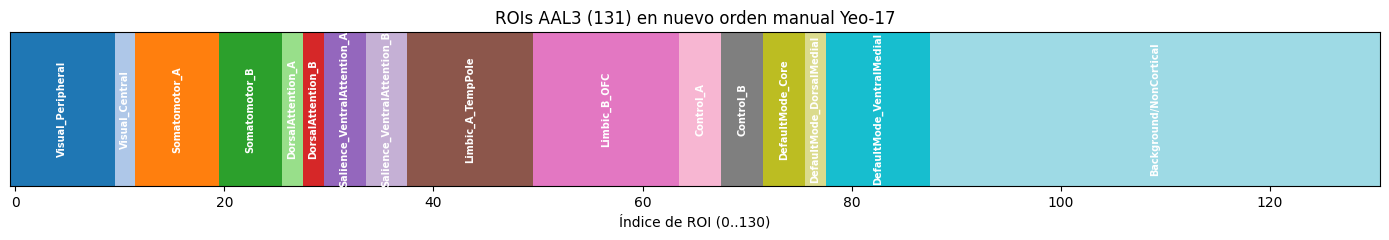

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df_map = pd.read_csv(fem.AAL3_MANUAL_NETWORK_MAPPING_CSV)

net_col_candidates = ["Yeo17_Network_manual", "Yeo17_Network", "NetworkName", "Network"]
net_col = next((c for c in net_col_candidates if c in df_map.columns), None)
if net_col is None:
    raise ValueError(f"No pude encontrar columna de nombre de red entre: {net_col_candidates}")

networks = df_map[net_col].values
unique_networks = list(dict.fromkeys(networks))  # preserva orden de aparición
net_to_int = {net: i for i, net in enumerate(unique_networks)}
network_colors = [net_to_int[n] for n in networks]

plt.figure(figsize=(14, 2.5))
plt.imshow([network_colors], aspect="auto", cmap="tab20")
plt.yticks([])
plt.xlabel("Índice de ROI (0..130)")
plt.title("ROIs AAL3 (131) en nuevo orden manual Yeo-17")

for net in unique_networks:
    idx = np.where(networks == net)[0]
    if len(idx) == 0:
        continue
    center = np.mean(idx)
    plt.text(center, 0, net, rotation=90, ha="center", va="center",
             fontsize=7, color="white", fontweight="bold")

plt.tight_layout()
plt.show()


In [5]:
import numpy as np
from pathlib import Path
import os

# --- CONFIGURACIÓN ---
PROJECT_ROOT = Path("..").resolve()
DATA_DIR = PROJECT_ROOT / "data"

# 1. Buscar la carpeta de resultados de COVID (La más reciente)
# Buscamos el patrón que definimos en el script: "COVID_AAL3_Tensor_v1..."
covid_results_dirs = sorted(list(DATA_DIR.glob("COVID_AAL3_Tensor_v1*")), key=os.path.getmtime, reverse=True)

if not covid_results_dirs:
    raise FileNotFoundError("❌ No se encontró la carpeta de resultados de COVID. Verifica que el script terminó correctamente.")

latest_covid_dir = covid_results_dirs[0]
print(f"📂 Carpeta COVID detectada: {latest_covid_dir.name}")

# 2. Cargar el Tensor Global
global_npz_path = list(latest_covid_dir.glob("GLOBAL_TENSOR*.npz"))[0]
print(f"📄 Cargando archivo: {global_npz_path.name}")

with np.load(global_npz_path) as data:
    G_covid = data["global_tensor_data"]     # (N_subjects, N_channels, 131, 131)
    subs_covid = data["subject_ids"]
    chans_covid = data["channel_names"]
    roi_order_name = data["roi_order_name"]
    roi_names_covid = data["roi_names_in_order"]
    net_labels_covid = data["network_labels_in_order"]

print("\n✅ TENSOR COVID CARGADO:")
print(f"   Shape: {G_covid.shape}  <-- Debe ser (194, 7, 131, 131)")
print(f"   Canales: {chans_covid}")
print(f"   Orden ROIs: {roi_order_name}")

print("\nVerificación de Primeras 10 ROIs (Debe coincidir con Visual/Peripheral):")
for i in range(10):
    print(f"{i:3d} {roi_names_covid[i]:25s} → {net_labels_covid[i]}")

📂 Carpeta COVID detectada: COVID_AAL3_Tensor_v1_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned
📄 Cargando archivo: GLOBAL_TENSOR_from_COVID_AAL3_Tensor_v1_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz

✅ TENSOR COVID CARGADO:
   Shape: (194, 7, 131, 131)  <-- Debe ser (194, 7, 131, 131)
   Canales: ['Pearson_OMST_GCE_Signed_Weighted' 'Pearson_Full_FisherZ_Signed'
 'MI_KNN_Symmetric' 'dFC_AbsDiffMean' 'dFC_StdDev' 'DistanceCorr'
 'Granger_F_lag1']
   Orden ROIs: aal3_manual_yeo17_order

Verificación de Primeras 10 ROIs (Debe coincidir con Visual/Peripheral):
  0 Cuneus_L                  → Visual_Peripheral
  1 Fusiform_L                → Visual_Peripheral
  2 Lingual_L                 → Visual_Peripheral
  3 Occipital_Inf_L           → Visual_Peripheral
  4 Occipital_Sup_L           → Visual_Peripheral
  5 Cuneus_R                  → Visual_Peripheral
  6 Fusiform_R                → Visual_Peripheral
  7 Lingual_R  

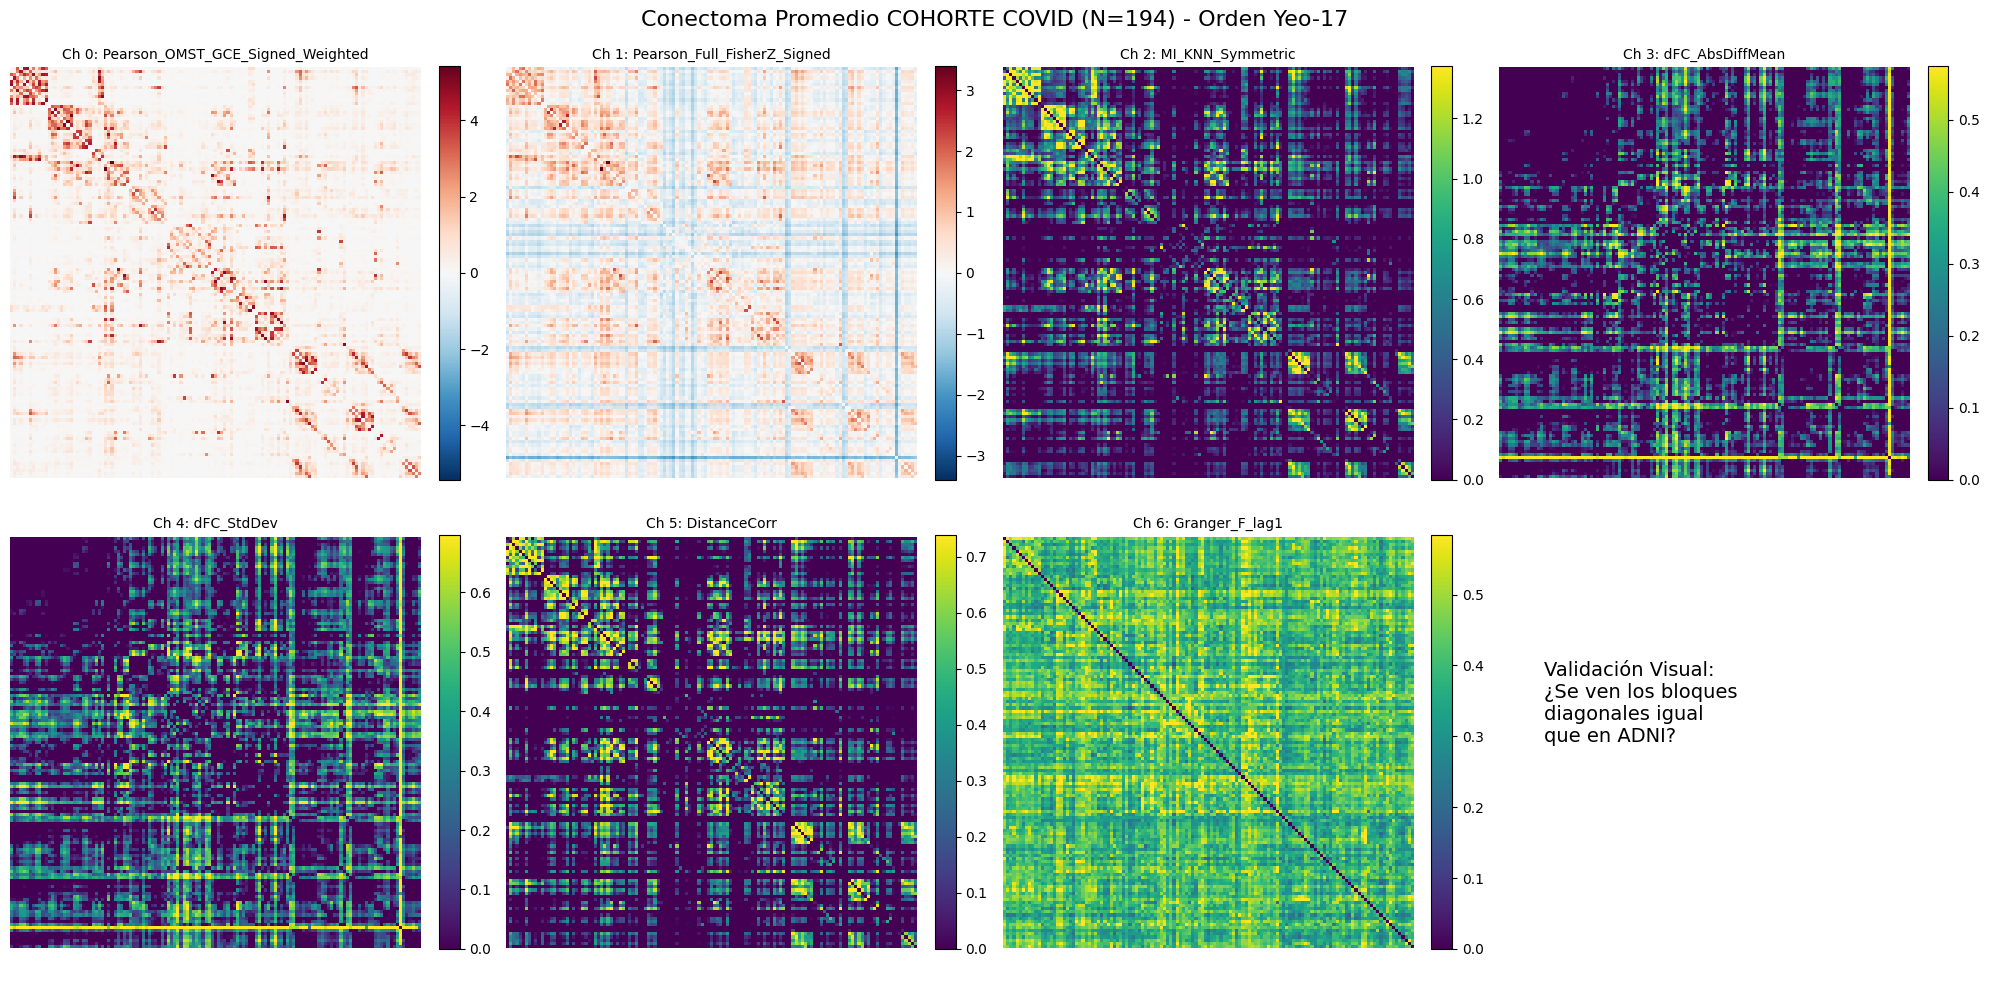

In [6]:
import matplotlib.pyplot as plt

# Promedio de todos los sujetos COVID
mean_connectome_covid = np.mean(G_covid, axis=0)

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

fig.suptitle(f"Conectoma Promedio COHORTE COVID (N={len(subs_covid)}) - Orden Yeo-17", fontsize=16)

for i, ch_name in enumerate(chans_covid):
    matrix = mean_connectome_covid[i]
    
    # Ajuste de color idéntico al de Alzheimer para comparar visualmente
    if "Pearson" in ch_name:
        cmap = 'RdBu_r'
        vmax = np.max(np.abs(matrix))
        vmin = -vmax
    else:
        cmap = 'viridis'
        vmin = 0
        vmax = np.percentile(matrix, 98) 
    
    im = axes[i].imshow(matrix, cmap=cmap, vmin=vmin, vmax=vmax, origin='upper')
    axes[i].set_title(f"Ch {i}: {ch_name}", fontsize=10)
    plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
    axes[i].axis('off')

# Ocultar subplot vacío
axes[7].axis('off')
axes[7].text(0.1, 0.5, f"Validación Visual:\n¿Se ven los bloques\ndiagonales igual\nque en ADNI?", fontsize=14)

plt.tight_layout()
plt.show()

In [7]:
import numpy as np

roi = np.array(roi_names_covid)  # Usamos los nombres cargados del tensor COVID

# Lógica de emparejamiento L-R
idx = {name: i for i, name in enumerate(roi)}
pairs = []
for name in roi:
    if name.endswith("_L"):
        r = name[:-2] + "_R"
        if r in idx:
            pairs.append(abs(idx[name] - idx[r]))

print("=== VALIDACIÓN DE TOPOLOGÍA (COVID) ===")
print(f"Nº Pares L-R detectados: {len(pairs)} (Esperado: 61)")
print(f"Distancia Mediana L-R:   {np.median(pairs)} (Esperado: 5.0)")
print(f"Distancia Min/Max:       {np.min(pairs)}, {np.max(pairs)} (Esperado: 1, 18)")

if np.median(pairs) == 5.0 and len(pairs) == 61:
    print("\n✅ CONCLUSIÓN: La estructura topológica es 100% equivalente a ADNI.")
    print("   El tensor está listo para INFERENCIA en el VAE.")
else:
    print("\n⚠️ ADVERTENCIA: Hay discrepancias topológicas. No realices inferencia todavía.")

=== VALIDACIÓN DE TOPOLOGÍA (COVID) ===
Nº Pares L-R detectados: 61 (Esperado: 61)
Distancia Mediana L-R:   5.0 (Esperado: 5.0)
Distancia Min/Max:       1, 18 (Esperado: 1, 18)

✅ CONCLUSIÓN: La estructura topológica es 100% equivalente a ADNI.
   El tensor está listo para INFERENCIA en el VAE.


In [8]:
import numpy as np
from pathlib import Path

# Asumiendo que ya hiciste:
# from betavae_xai import feature_extraction_manual_COVID as fem_covid
# from importlib import reload; reload(fem_covid)

output_dir = Path(fem_covid.BASE_PATH_AAL3) / fem_covid.OUTPUT_CONNECTIVITY_DIR_NAME
global_npz_path = next(output_dir.glob("GLOBAL_TENSOR_from_*.npz"))
print("GLOBAL_TENSOR path:", global_npz_path)

with np.load(global_npz_path, allow_pickle=True) as data:
    G = data["global_tensor_data"]        # (N_subjects, N_channels, 131, 131)
    subs = data["subject_ids"]
    chans = data["channel_names"]
    roi_order_name = data["roi_order_name"]
    roi_names = data["roi_names_in_order"]
    net_labels = data["network_labels_in_order"]

print("GLOBAL_TENSOR shape:", G.shape)
print("Sujetos:", len(subs))
print("Canales:", list(map(str, chans)))
print("ROI order name:", str(roi_order_name))

print("\nPrimeras 10 ROIs en orden global:")
for i in range(10):
    print(f"{i:3d} {str(roi_names[i]):25s} → {str(net_labels[i])}")


GLOBAL_TENSOR path: /home/diego/proyectos/betavae-xai-ad/data/COVID_AAL3_Tensor_v1_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/GLOBAL_TENSOR_from_COVID_AAL3_Tensor_v1_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz
GLOBAL_TENSOR shape: (194, 7, 131, 131)
Sujetos: 194
Canales: ['Pearson_OMST_GCE_Signed_Weighted', 'Pearson_Full_FisherZ_Signed', 'MI_KNN_Symmetric', 'dFC_AbsDiffMean', 'dFC_StdDev', 'DistanceCorr', 'Granger_F_lag1']
ROI order name: aal3_manual_yeo17_order

Primeras 10 ROIs en orden global:
  0 Cuneus_L                  → Visual_Peripheral
  1 Fusiform_L                → Visual_Peripheral
  2 Lingual_L                 → Visual_Peripheral
  3 Occipital_Inf_L           → Visual_Peripheral
  4 Occipital_Sup_L           → Visual_Peripheral
  5 Cuneus_R                  → Visual_Peripheral
  6 Fusiform_R                → Visual_Peripheral
  7 Lingual_R                 → Visual_Peripheral
  8 Occipital_Inf_R  

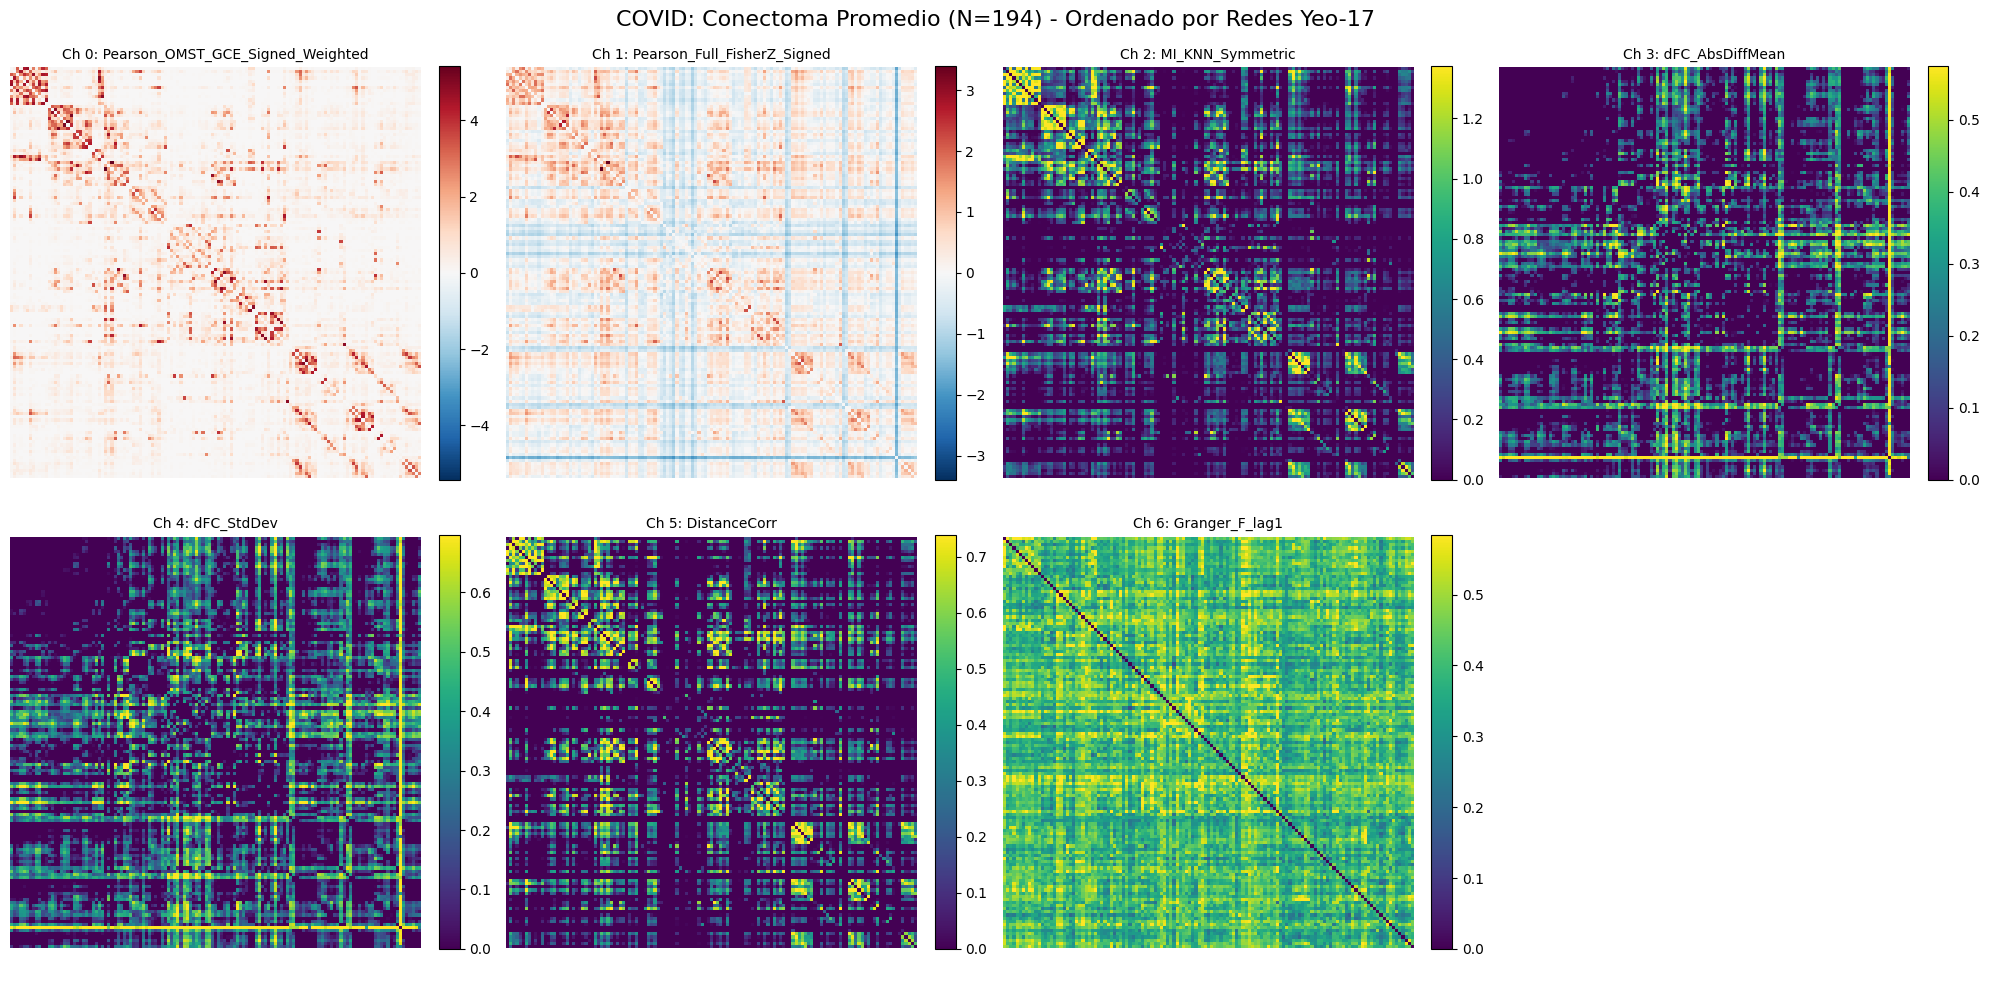

Interpretación Visual (QC rápido):
- Pearson/OMST (Pearson_*): deberían verse bloques/estructura y valores +/- (rojo/azul).
- MI/dFC/DistanceCorr/Granger: suelen ser no-negativos; buscá contraste y bloques por red.
- Si ves bloques diagonales, el reordenamiento Yeo-17 está funcionando.


In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Reutiliza lo cargado en la celda anterior: G, chans, subs, roi_names
global_tensor = G
channel_names = list(map(str, chans))
subject_ids = subs

mean_connectome = np.mean(global_tensor, axis=0)  # (C, 131, 131)

n_channels = len(channel_names)
nrows = 2
ncols = int(np.ceil(n_channels / nrows))

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows))
axes = np.array(axes).reshape(-1)

fig.suptitle(
    f"COVID: Conectoma Promedio (N={len(subject_ids)}) - Ordenado por Redes Yeo-17",
    fontsize=16
)

for i, ch_name in enumerate(channel_names):
    matrix = mean_connectome[i]

    # Pearson / Signed -> diverging; el resto normalmente no-negativo
    if ("Pearson" in ch_name) or ("Signed" in ch_name):
        cmap = "RdBu_r"
        vmax = np.max(np.abs(matrix))
        vmin = -vmax
    else:
        cmap = "viridis"
        vmin = 0
        vmax = np.percentile(matrix, 98)

    im = axes[i].imshow(matrix, cmap=cmap, vmin=vmin, vmax=vmax, origin="upper")
    axes[i].set_title(f"Ch {i}: {ch_name}", fontsize=10)
    plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
    axes[i].axis("off")

# Apagar subplots vacíos si sobran
for j in range(n_channels, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

print("Interpretación Visual (QC rápido):")
print("- Pearson/OMST (Pearson_*): deberían verse bloques/estructura y valores +/- (rojo/azul).")
print("- MI/dFC/DistanceCorr/Granger: suelen ser no-negativos; buscá contraste y bloques por red.")
print("- Si ves bloques diagonales, el reordenamiento Yeo-17 está funcionando.")


In [10]:
import numpy as np

roi = np.array(list(map(str, roi_names)))

idx = {name: i for i, name in enumerate(roi)}
pairs = []
missing = []

for name in roi:
    if name.endswith("_L"):
        r = name[:-2] + "_R"
        if r in idx:
            pairs.append(abs(idx[name] - idx[r]))
        else:
            missing.append((name, r))

pairs = np.array(pairs, dtype=int)

print("n pares L/R:", len(pairs))
print("distancia mediana L-R:", float(np.median(pairs)) if len(pairs) else None)
print("distancia min/max:", (int(np.min(pairs)), int(np.max(pairs))) if len(pairs) else None)
print("pares L sin R encontrado:", len(missing))
if missing[:5]:
    print("Ejemplos missing:", missing[:5])


n pares L/R: 61
distancia mediana L-R: 5.0
distancia min/max: (1, 18)
pares L sin R encontrado: 1
Ejemplos missing: [(np.str_('Cerebelum_10_L'), 'Cerebelum_10_R')]


In [11]:
import numpy as np
from betavae_xai import feature_extraction_manual as fem_ad  # el de Alzheimer/ADNI

covid_chans = list(map(str, chans))
ad_chans = list(map(str, fem_ad.CONNECTIVITY_CHANNEL_NAMES))

print("COVID channels:", covid_chans)
print("AD expected   :", ad_chans)
print("Mismo set?    :", set(covid_chans) == set(ad_chans))
print("Mismo orden?  :", covid_chans == ad_chans)

if covid_chans != ad_chans:
    print("\n⚠️ Importante: el ORDEN de canales no coincide. Para inferencia tenés 2 opciones:")
    print("1) Reordenar G por canales para igualar ad_chans.")
    print("2) Recalcular el tensor COVID con el mismo orden (más limpio).")

# Chequeo ROI order name (no es suficiente, pero ayuda)
print("\nROI order (COVID):", str(roi_order_name))
print("ROI order (AD)   :", "aal3_manual_yeo17_order (esperado en tu pipeline AD)")


2026-02-06 13:57:30,850 - INFO - feature_extraction_manual.py:52 - Successfully imported 'threshold_omst_global_cost_efficiency' from 'dyconnmap.graphs.threshold' and aliased as 'orthogonal_minimum_spanning_tree'.
2026-02-06 13:57:30,851 - INFO - feature_extraction_manual.py:186 - Global MAX_WORKERS for ProcessPoolExecutor set to: 6 (based on 12 total cores)
2026-02-06 13:57:30,851 - INFO - feature_extraction_manual.py:445 - --- Initializing AAL3 ROI Processing Information ---
2026-02-06 13:57:30,857 - INFO - feature_extraction_manual.py:484 - AAL3 ROI processing info initialized (prior to reordering attempt):
2026-02-06 13:57:30,858 - INFO - feature_extraction_manual.py:485 -   Indices of 4 AAL3 systemically missing ROIs (0-based, from 170): [34, 35, 80, 81]
2026-02-06 13:57:30,858 - INFO - feature_extraction_manual.py:486 -   Number of ROIs in AAL3 meta after excluding systemically missing: 166 (Expected: 166)
2026-02-06 13:57:30,859 - INFO - feature_extraction_manual.py:487 -   Indi

COVID channels: ['Pearson_OMST_GCE_Signed_Weighted', 'Pearson_Full_FisherZ_Signed', 'MI_KNN_Symmetric', 'dFC_AbsDiffMean', 'dFC_StdDev', 'DistanceCorr', 'Granger_F_lag1']
AD expected   : ['Pearson_OMST_GCE_Signed_Weighted', 'Pearson_Full_FisherZ_Signed', 'MI_KNN_Symmetric', 'dFC_AbsDiffMean', 'dFC_StdDev', 'DistanceCorr', 'Granger_F_lag1']
Mismo set?    : True
Mismo orden?  : True

ROI order (COVID): aal3_manual_yeo17_order
ROI order (AD)   : aal3_manual_yeo17_order (esperado en tu pipeline AD)
